In [1]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk.classify.util
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import plot_confusion_matrix

from tqdm import tqdm

import re
from bs4 import BeautifulSoup
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#read the data
reviews=pd.read_csv("Reviews.csv", encoding = "ISO-8859-1")
reviews=reviews[:40000]
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#Lets convert our sccores to three labels 0,1,2 for , negative(score<3),Positive(score>3),neutral(score==3)
def label(x):
    if x>3:
        return 1
    elif x<3:
        return 0
    elif x==3:
        return 2
reviews["Score"]=reviews["Score"].map(label)
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#lets check if our data is having duplicate values
reviews[reviews[["UserId","ProfileName","Time","Text"]].duplicated()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,1,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,2,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,0,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,0,1127606400,Below standard,Too much of the white pith on this orange peel...
...,...,...,...,...,...,...,...,...,...,...
39976,39977,B001TZJ3OE,A3908E1G8IL52G,Jessica Ztardust,1,2,1,1312243200,Highly Addicting!,I did not purchase this product off of Amazon....
39977,39978,B001TZJ3OE,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...
39978,39979,B001TZJ3OE,A1VTHOTQFPRFVT,jumperboy,0,1,2,1301961600,"Just Okay, Too Sweet",I was excited to try this sauce based on the r...
39979,39980,B001TZJ3OE,AAJ1IYOUIHWF,D. Sun,1,11,2,1243036800,Too much,These are very large bottles. It is a good dip...


In [5]:
# we can see in the above cell that there are duplicates in our data. Lets drop all of them.
print("Data set size before dropping duplicates",reviews.shape)

reviews_df = reviews.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first')

print("Data set size after dropping duplicates",reviews_df.shape)

Data set size before dropping duplicates (40000, 10)
Data set size after dropping duplicates (37452, 10)


In [6]:
#let us find if our data have any missing values
# from now on we deal only with Text and Score columns, Text is our feature and score is our label.
reviews_df[["Text","Score"]].isnull().any()

Text     False
Score    False
dtype: bool

In [7]:
print("Amount of data retianed is : ", reviews_df.shape[0]/reviews.shape[0])

Amount of data retianed is :  0.9363


In [8]:
#plt.bar(reviews_df["Score"].unique(),reviews_df["Score"].value_counts())
#plt.xticks([0,1,2])
#plt.show()

Text(0.5, 1.0, 'Labels')

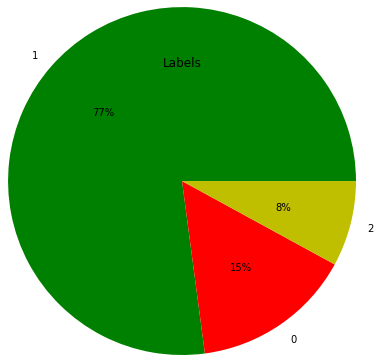

In [9]:
plt.pie(reviews_df["Score"].value_counts(),autopct='%1.0f%%',radius=2,labels=reviews_df["Score"].unique(),colors=["g","r","y"])
plt.title("Labels")

#### Observations:
1. After removing duplicates and missing values we were able to retain 93.6% of actual data.
2. From the above bar plot we can clearly see that our data is imbalanced, biased towards to class 1(positive).

# 3. Data Preprocessing

In [10]:
#21,15,28
review34=reviews_df["Text"][34]
review34

"Instant oatmeal can become soggy the minute the water hits the bowl. McCann's Instant Oatmeal holds its texture, has excellent flavor, and is good for you all at the same time. McCann's regular oat meal is excellent, too, but may take a bit longer to prepare than most have time for in the morning. This is the best instant brand I've ever eaten, and a very close second to the non-instant variety.<br /><br />McCann's Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)"

In [11]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
reviews_df=reviews_df[["Text","Score"]]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
print(stop_words)

{'ours', 'aren', "shan't", 'has', 's', 'while', 'by', 'shan', 'if', 'because', 'as', "mightn't", 'same', 't', 'is', 'some', 'after', 'more', 'through', 'into', 'than', "she's", 'nor', 'there', 'mightn', 'with', 'in', 'and', 'can', 'ain', 'again', 'do', 'their', 'be', 'should', 'didn', 'herself', 'so', 'just', 'she', 'down', 'his', 'how', 'any', "shouldn't", 'couldn', 'these', 'yours', "couldn't", 'needn', 'hers', "isn't", 'an', 'isn', 'we', 'your', "that'll", 'doing', 'above', 'those', 'before', 'll', "hadn't", "haven't", 'o', 'who', 'further', 'only', 'whom', 'd', 'doesn', 'having', 'theirs', 'they', 'itself', 'am', 'were', "wouldn't", "won't", 'hadn', 'myself', 'where', 'for', 'then', 'to', 'most', 'my', 'own', 'i', 'against', 'of', 'up', 'ourselves', 'had', 'off', 'he', "needn't", 'which', 'both', 'it', 'him', 'about', 'when', 'very', 'yourself', 'you', 'why', "don't", 'under', 'did', "you've", 'weren', 'such', 'y', 'what', 'wouldn', 'during', 'm', 'been', 'themselves', 'them', 'all

In [13]:
#let us remove word not from stop words, since it is the one of the most important word in classifing the review.
stop_words.remove("not")

In [14]:
def text_Preprocessing(reviews):
    
    
    """ This will clean the text data, remove html tags, remove special characters and then tokenize the reviews to apply Stemmer on each word token."""
    
    pre_processed_reviews=[]
    
    for review in tqdm(reviews):
        review= BeautifulSoup(review,'lxml').getText()    #remove html tags
        review=re.sub('\S*\d\S*','',review).strip()
        review=re.sub('[^A-Za-z]+',' ',review)        #remove special chars
        review=re.sub("n't","not",review)
        review=word_tokenize(str(review.lower())) #tokenize the reviews into word tokens

        # now we will split the review into words and then check if these words are in the stop words if so we will remove them, if not we will join
        review=' '.join(PorterStemmer().stem(word) for word in review if word not in stop_words)
        pre_processed_reviews.append(review.strip())
    return pre_processed_reviews

In [15]:
preprocessed_reviews=text_Preprocessing(reviews_df["Text"])
preprocessed_reviews[34]

100%|██████████| 37452/37452 [03:33<00:00, 175.52it/s]


'mccann instant irish oatmeal varieti pack regular appl cinnamon mapl brown sugar box pack fan mccann steel cut oat thought give instant varieti tri found hardi meal not sweet great folk like post bariatr surgeri need food palat easili digest fiber make bloat'

In [16]:
preprocessed_reviews=pd.DataFrame({"text":preprocessed_reviews,"sentiment":reviews_df.Score})
preprocessed_reviews.head()

,text,sentiment
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


In [17]:
preprocessed_reviews.sentiment.value_counts()    #1-positive-28875    # 0-5597   #2-nuetral-2980

1    28875
0     5597
2     2980
Name: sentiment, dtype: int64

Observations:
1. we cleaned our text data, removed unnecessary tags
2. Though we cleaned our data, it is still in string format which computers won't understand, for this we use text featuration.

### 3.1.Featurization

In [18]:
#It is best practice to split the data Before we do text featurization 
reviews_train,reviews_test,sentiment_train,sentiment_test=train_test_split(preprocessed_reviews.text,preprocessed_reviews.sentiment)
print(reviews_train.shape,reviews_test.shape)
print(sentiment_train.shape,sentiment_test.shape)

(28089,) (9363,)
(28089,) (9363,)


In [19]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=6000)
tfidf_model.fit(reviews_train,sentiment_train)
reviews_train_tfidf=tfidf_model.transform(reviews_train)
reviews_test_tfidf=tfidf_model.transform(reviews_test)
reviews_train_tfidf.shape,reviews_test_tfidf.shape

((28089, 6000), (9363, 6000))

In [20]:
tfidf_df=pd.DataFrame(reviews_train_tfidf.toarray(),columns=tfidf_model.get_feature_names(),index=reviews_train.index)
tfidf_df

,abil,abl,abl buy,abl find,abl get,abl order,absolut,absolut best,absolut delici,absolut favorit,...,zealand,zero,zero calori,zing,zip,zip lock,zipfizz,ziploc,ziwipeak,zuke
39997,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38453,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23492,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21098,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36086,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7584,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9750,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3986,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Lets checkout the top features
top_features=sorted(zip(tfidf_model.idf_,tfidf_model.get_feature_names()))
top10=top_features[:10]


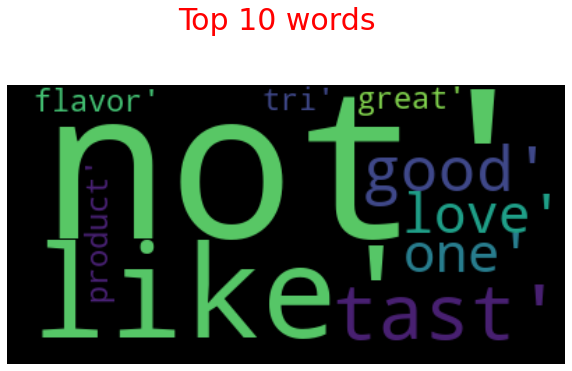

In [22]:
from wordcloud import WordCloud
plt.figure(figsize=(10,8))
wc = WordCloud(background_color="black",max_font_size=150, random_state=42)
wc.generate(str(top10))
plt.imshow(wc, interpolation='bilinear')
plt.suptitle('Top 10 words', size=30, y=0.88,color="r"); 
plt.axis("off")
plt.savefig("top10_words.png")
plt.show()

# 4. Modeling

## 4.1. Logistic regression

In [23]:
# Logistic Regression with default parameters
lr=LogisticRegression(max_iter=1000)
lr.fit(reviews_train_tfidf,sentiment_train)
lr_predict=lr.predict(reviews_test_tfidf)
plain_lr_f1=f1_score(sentiment_test,lr_predict,average="weighted")
plain_lr_f1

0.815462380739397

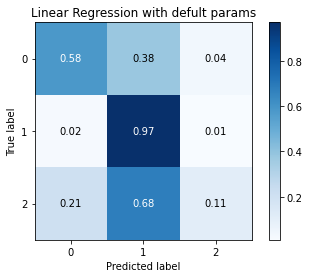

In [24]:
plot_confusion_matrix(sentiment_test,lr_predict,normalize=True)
plt.title("Linear Regression with defult params")
plt.show()

In [25]:
from imblearn.over_sampling import SMOTE
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_resample(reviews_train_tfidf,sentiment_train)
oversampled_trainY.value_counts()

2    21684
1    21684
0    21684
Name: sentiment, dtype: int64

In [26]:
# we will tune the parameters of Logistic Regression with RandomizedsearchCV
lr_params={"penalty":["l1","l2"],
           "C":[10**i for i in range(-4,4)]}
lr=LogisticRegression( max_iter=1000,solver="liblinear")
lr_rnm_clf=RandomizedSearchCV(lr,lr_params)
lr_rnm_clf.fit(oversampled_trainX,oversampled_trainY)
lr_rnm_clf.best_params_

{'penalty': 'l1', 'C': 1000}

In [27]:
lr_bal=LogisticRegression(**lr_rnm_clf.best_params_, max_iter=1000,solver="liblinear")
lr_bal.fit(oversampled_trainX,oversampled_trainY)
lr_bal_predict=lr_bal.predict(reviews_test_tfidf)
lr_bal_f1=f1_score(lr_bal_predict,sentiment_test,average="weighted")
lr_bal_f1

0.7602155457204536

Text(0.5, 1.0, 'Logistic regression Confusion matrix')

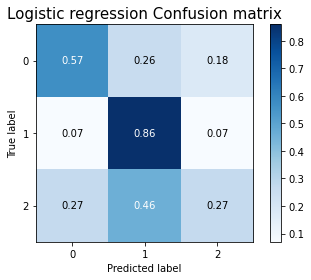

In [28]:
plot_confusion_matrix(sentiment_test,lr_bal_predict,normalize=True)
plt.title("Logistic regression Confusion matrix",size=15)

## 4.2. Support Vector Classifier

In [29]:
from sklearn.svm import LinearSVC
svc_params={'penalty':['l1','l2'],
        'C':[10**i for i in range(-4,4)]}
svc_model=LinearSVC(dual=False,max_iter=5000)
rndm_clf=RandomizedSearchCV(svc_model,svc_params)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
svc_best_params=rndm_clf.best_estimator_

C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [30]:
svc_best_params

LinearSVC(C=1000, dual=False, max_iter=5000)

In [31]:
svc_model=LinearSVC(C=1000, dual=False, max_iter=5000)
svc_model.fit(oversampled_trainX,oversampled_trainY)
svc_predict=svc_model.predict(reviews_test_tfidf)
svc_f1=f1_score(sentiment_test,svc_predict,average="weighted")
svc_f1

0.7753231827107946

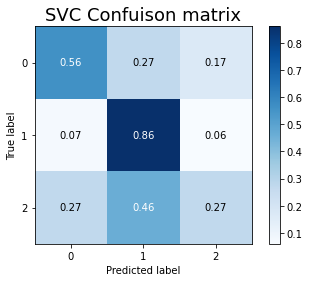

In [32]:
plot_confusion_matrix(sentiment_test,svc_predict,normalize=True)
plt.title("SVC Confuison matrix",size=18)
plt.show()

## 4.3. Decision Trees

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt_param={'max_depth':[i for i in range(5,2000,3)],
         'min_samples_split':[i for i in range(5,2000,3)]}
dt_clf=DecisionTreeClassifier()
rndm_clf=RandomizedSearchCV(dt_clf,dt_param)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
dt_best_params=rndm_clf.best_params_

In [34]:
dt_clf=DecisionTreeClassifier(**dt_best_params)
dt_clf.fit(oversampled_trainX,oversampled_trainY)
dt_predict=dt_clf.predict(reviews_test_tfidf)
dt_f1=f1_score(sentiment_test,svc_predict,average="weighted")
dt_f1

0.7753231827107946

Text(0.5, 1.0, 'Decision Tree Confuison matrix')

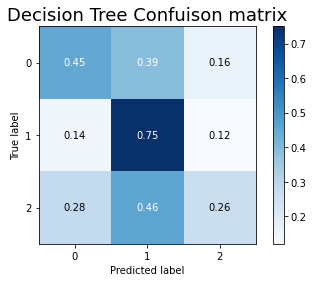

In [35]:
plot_confusion_matrix(sentiment_test,dt_predict,normalize=True)
plt.title("Decision Tree Confuison matrix",size=18)


## 4.4. Naive Bayes:

In [36]:
nb_params={"alpha":[10**i for i in range(-5,5)]}
nb_clf=MultinomialNB()
rndm_clf=RandomizedSearchCV(nb_clf,nb_params)
#rndm_clf.fit(oversampled_trainX,oversampled_trainY)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
nb_best_params=rndm_clf.best_params_

nb_clf=MultinomialNB(**nb_best_params)
nb_clf.fit(oversampled_trainX,oversampled_trainY)
nb_predict=nb_clf.predict(reviews_test_tfidf)
nb_f1=f1_score(sentiment_test,nb_predict,average="weighted")
nb_f1

0.7780366257981816

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

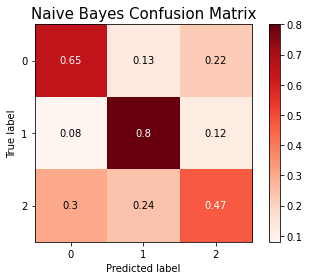

In [37]:
plot_confusion_matrix(sentiment_test,nb_predict,normalize=True,cmap="Reds")
plt.title("Naive Bayes Confusion Matrix",size=15)

## 4.5. Random Forrests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_rf={'max_depth':[2,3,4,5,6,7,8,9,10],'n_estimators':[i for i in range(1,1000,5)]}
clf=RandomForestClassifier()
rndm_clf=RandomizedSearchCV(clf,param_rf)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
rf_best_params=rndm_clf.best_params_


In [ ]:
rf_clf=RandomForestClassifier(**rf_best_params,class_weight='balanced')
rf_clf.fit(oversampled_trainX,oversampled_trainY)
rf_predict=rf_clf.predict(reviews_test_tfidf)

In [ ]:
plot_confusion_matrix(sentiment_test,rf_predict,normalize=True)
plt.title("Random forrests Confusion Matrix",size=15)

In [ ]:
rf_f1=f1_score(sentiment_test,rf_predict,average="weighted")
rf_f1

# 5. Model evaluation:
    

In [ ]:
models=["LinearRegression","DecisionTrees","SVM","NaiveBayes","Random Forrests"]
f1_scores=[lr_bal_f1,dt_f1,svc_f1,nb_f1,rf_f1]

In [ ]:
plt.figure(figsize=(6,5))
plt.barh(models,f1_scores,color=['c','r','m','y','b'])
plt.title("F1 Scores of all models",size=20)
for index, value in enumerate(f1_scores):
    plt.text(0.9,index,str(round(value,2)))
plt.xlabel('F1_SCores',size=15)
plt.ylabel("Models",size=15)
plt.savefig("f1_scores.png")
plt.show()


In [ ]:
#After evaluating all model we have found that svm and decision tree are two best suited models for our project .


In [44]:
# lets save the model
import pickle
pickle.dump(svc_model,open("nb_clf.pkl","wb"))
pickle.dump(tfidf_model,open("tfidf_model.pkl","wb"))

In [ ]:
#After evaluating all model we have found that svm and decision tree are two best suited models for our project .
